In [2]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("pastel") 

# Загрузка и обработка данных

In [3]:
data = pd.read_csv('data/ds_salaries.csv')
data.head(1)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


## Формирование отчета

Для рассмотрения общей структуры и первичной оценке данных, сформируем отчет

In [5]:
# Отчет уже сформирован.
# Если возникла необходимость пересоздать(проверить), просто раскомментируйте и запустите
# profile = ProfileReport(data)
# profile.to_file('./data/DS_salary_analyze_before.html')

Рассмотрим корреляционную матрицу:  
![Корреляционная матрица данных по зарплатам](./data/corr_heatmap.jpg)

Поиск несбалансированных переменных:
* В нашем случае, если больше 90% занимает одна переменная

In [6]:
# Отбор категорий, в которых больше чем 90% занимает одна величина
high_freq_categories = []
for column in data.columns:
    freqency = data[column].value_counts(normalize=True)
    if not freqency[freqency > 0.9].empty:
        high_freq_categories.append(column)

display(high_freq_categories)

['employment_type']

При рассмотрении корреляционной матрицы и первичном анализе параметров, иммет смысл удалить следующие:
* Unnamed: 0 - Безсмысленный параметр, повторяющий индексацию;
* salary - В данных есть параметр, обозначающий зарплату в USD - salary_to_usd, следовательно, этот параметр больше неинформативен;
* salary_currency - Если удаляем зарплату в валюте, то валюта нам больше не нужна по определению;
* company_location - параметр с мультиколлинеарностью
* employment_type - ~97% значений занимает один тип (FT), остальные 3 значения ~1%.

### Удаление неинформативных признаков

In [7]:
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency', 'company_location', 'employment_type'], axis=1)

### Поиск дубликатов и нулевых значений

In [8]:
# Удаление дубликотов
data = data.drop_duplicates()
# Определение количества нулевых значений в каждом параметре
data.isna().sum()

work_year             0
experience_level      0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_size          0
dtype: int64

### Классификация признаков

В данных все признаки являются категориальными, кроме:
* salary_in_usd - заработная плата в USD

Несмотря на то, что значения признака *remote_ratio* предсавлены числами, он является **категориальным**. Это связано с тем, что данный признак принимает значения-ярлыки, которые просто представляют разные уровни удаленной работы.  
Тоже самое можно сказать признак *work_year* - он является **категориальным**. Потому что мы рассматриваем не временной промежутоки тенденции изменения от года к году, а просто 3 группы работников, которые получали зарплату за определенный год (2020, 2021, 2022)


Перевод числовыъ признаков в категориальные

In [9]:
data['remote_ratio'] = data['remote_ratio'].astype('object')
data['work_year'] = data['work_year'].astype('object')

Преобразвание 

In [10]:
def frequency_adjustment(data: pd.DataFrame, num_significant: int, *features: str) -> pd.DataFrame:
    """
    Оставляет num_significant элементов в feature без изменений, остальные группируются в 'other'

    Args:
        data (pd.DataFrame): Изначальный DataFrame;
        num_significant (int): количество значимых элементов, которые остануться без изменения;
        *features - признаки, которые надо преобразовать.
    
    Returns:
        pd.DataFrame: DataFrame после преобразования
            Преобразует DataGrame по определенному признаку следующим образом:
    
    Пример вызова:
        data = frequency_adjustment(data, 10, 'job_title', 'employee_residence')
    """
    
    
    # Copy data to return it if have an Error
    data_without_changes = data.copy()
    
    for feature in features:
        # If feature does not exist
        try:
            frequency_feature = data[feature].value_counts().nlargest(num_significant).index.to_list()
            data[feature] = data[feature].apply(lambda x: x if x in frequency_feature else 'other')
        except KeyError:
            print(f'Feature {feature} is not exist!')
            return data_without_changes

    return data

data = frequency_adjustment(data, 10, 'job_title', 'employee_residence')

### Определение основных статистических характеристик

In [11]:
data.describe(include='all')

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_size
count,565.0,565,565,565.000000,565,565.0,565
unique,3.0,4,11,NaN,11,3.0,3
top,2022.0,SE,other,NaN,US,100.0,M
freq,278.0,243,131,NaN,295,346.0,290
mean,NaN,NaN,NaN,110610.343363,NaN,NaN,NaN
std,NaN,NaN,NaN,72280.702792,NaN,NaN,NaN
min,NaN,NaN,NaN,2859.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,60757.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,100000.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN


In [12]:
# profile = ProfileReport(data)
# profile.to_file('./data/DS_salary_analyze_after.html')

# Визуальный анализ данных

### Базовый анализ для каждого признака

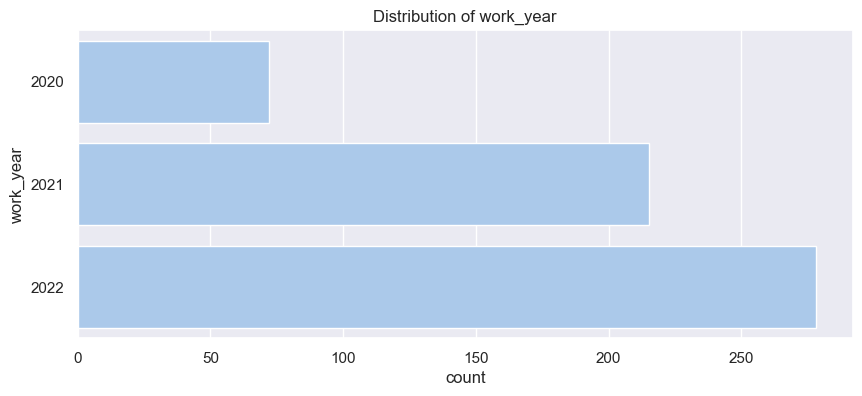

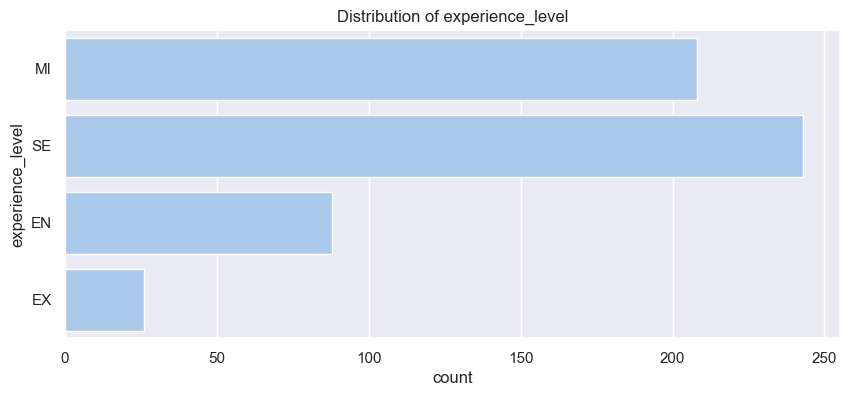

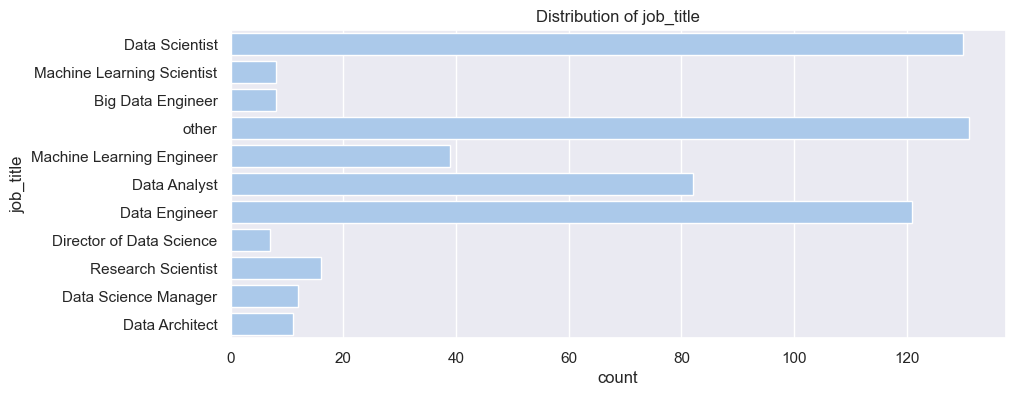

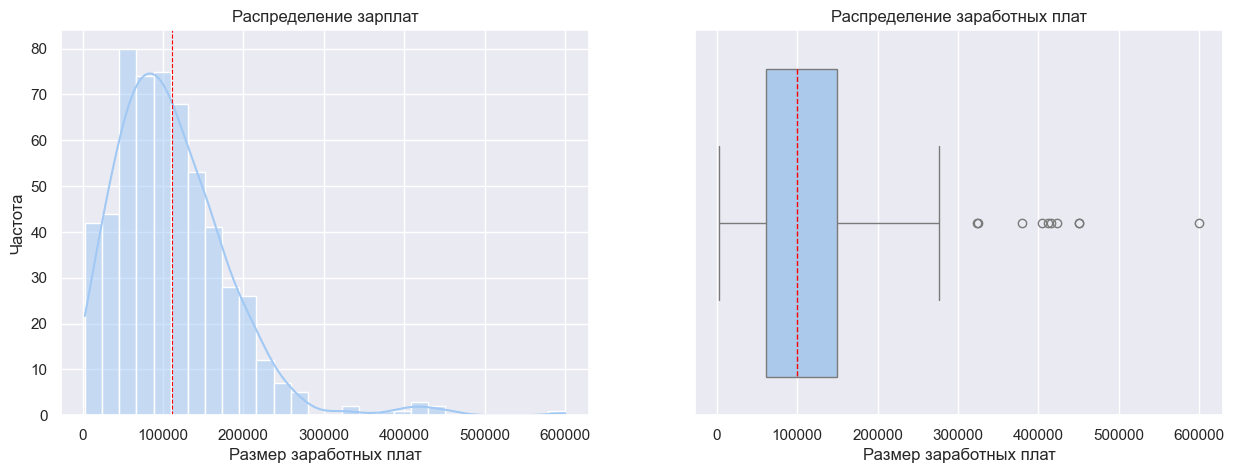

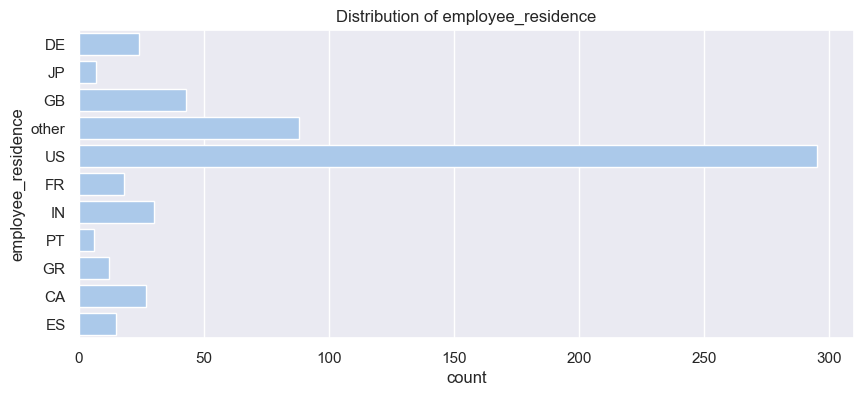

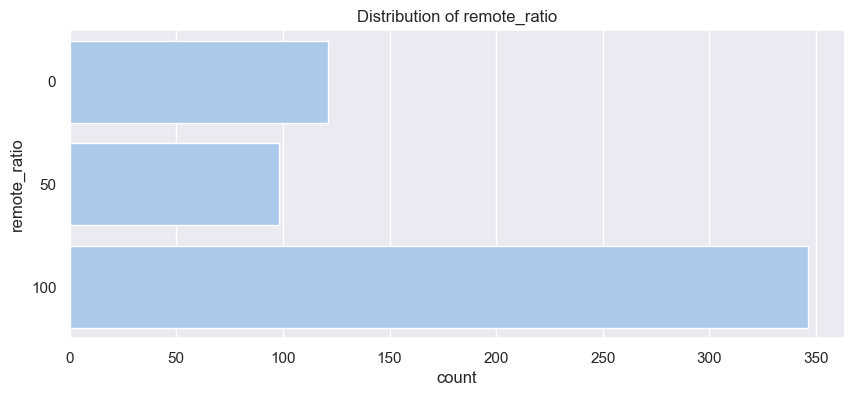

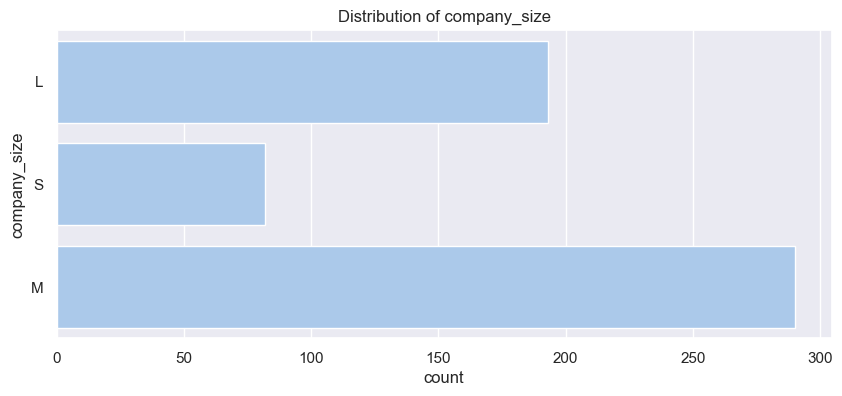

In [23]:
# Построение графиков для всех признаков, участвующих в анализе
for column in data.columns:
    # Если признак численный - histogram и boxplot
    if data[column].dtype == 'int64':
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        sns.histplot(data[column], kde=True, ax=axes[0])
        axes[0].set(xlabel=f'Amount {column}', ylabel='Frequency')
        axes[0].set_title(f'destribution of {column}')
        axes[0].axvline(data[column].mean(), color='red', linestyle='--', linewidth=0.8)

        sns.boxplot(data[column], ax=axes[1], orient='h', medianprops={'color': 'red', 'linestyle': '--'})
        axes[1].set(xlabel=f'Amount {column}')
        axes[1].set_title(f'destribution {column}')

        plt.show()
    # Если признак категориальный - countplot
    else:
        plt.figure(figsize=(10, 4))
        sns.countplot(y=column, data=data)
        plt.title(f'Distribution of {column}')
        plt.show()